In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

### <center>Data collection

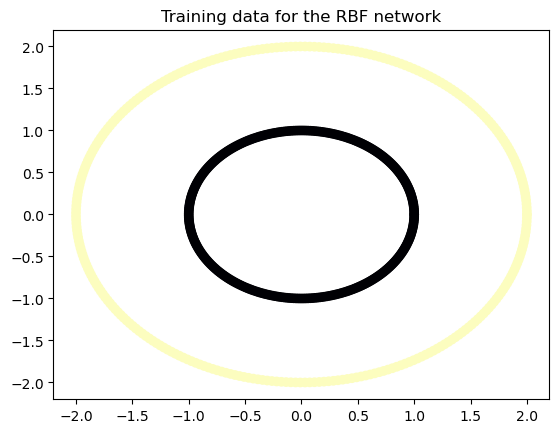

In [6]:
def generate_data(n_samples=300):
    angles = torch.linspace(0, 2*np.pi, n_samples)
    X1 = torch.stack([torch.cos(angles), torch.sin(angles)]).T * 1.0
    X2 = torch.stack([torch.cos(angles), torch.sin(angles)]).T * 2.0
    X = torch.vstack([X1, X2])
    y = torch.hstack([torch.zeros(n_samples), torch.ones(n_samples)])
    return X, y

X, y = generate_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='magma')
plt.title("Training data for the RBF network")
plt.show()

### <center>RBF

In [7]:
class RBFNet(nn.Module):
    def __init__(self, n_centers, n_out):
        super(RBFNet, self).__init__()
        self.n_centers = n_centers
        self.centers = nn.Parameter(torch.randn(n_centers, 2))
        self.sigmas = nn.Parameter(torch.ones(n_centers))
        self.linear = nn.Linear(n_centers, n_out)
        
    def rbf(self, X):
        diff = X.unsqueeze(1) - self.centers.unsqueeze(0)
        distances = torch.sum(diff**2, dim=2)
        return torch.exp(-distances / (2 * self.sigmas**2))
    
    def forward(self, X):
        rbf_out = self.rbf(X)
        return self.linear(rbf_out)
    
    def init_centers_kmeans(self, X):
        X_np = X.numpy() if isinstance(X, torch.Tensor) else X
        kmeans = KMeans(n_clusters=self.n_centers)
        kmeans.fit(X_np)
        with torch.no_grad():
            self.centers.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
    
    def fit(self, X, y, n_epochs=100, lr=0.01, verbose=True):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()
        
        for epoch in range(1, n_epochs+1):
            optimizer.zero_grad()
            outputs = self(X)
            loss = criterion(outputs.squeeze(), y)
            loss.backward()
            optimizer.step()
            
            if verbose and epoch % 10 == 0:
                print(f'RBF Epoch {epoch}, Loss: {loss.item():.4f}')

### <center>MLP

In [8]:
class MLP(nn.Module):
    def __init__(self, hidden_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.Tanh()
        
    def forward(self, X):
        out = self.activation(self.fc1(X))
        return self.fc2(out)
    
    def fit(self, X, y, n_epochs=100, lr=0.01, verbose=True):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()
        
        for epoch in range(1, n_epochs+1):
            optimizer.zero_grad()
            outputs = self(X)
            loss = criterion(outputs.squeeze(), y)
            loss.backward()
            optimizer.step()
            
            if verbose and epoch % 10 == 0:
                print(f'MLP Epoch {epoch}, Loss: {loss.item():.4f}')

### <center>RBF network training

In [9]:
rbf_net = RBFNet(n_centers=10, n_out=1)
rbf_net.init_centers_kmeans(X)
rbf_net.fit(X, y, n_epochs=50)

RBF Epoch 10, Loss: 0.6109
RBF Epoch 20, Loss: 0.5600
RBF Epoch 30, Loss: 0.5125
RBF Epoch 40, Loss: 0.4667
RBF Epoch 50, Loss: 0.4227


### <center>MLP training

In [10]:
mlp = MLP()
mlp.fit(X, y, n_epochs=50)

MLP Epoch 10, Loss: 0.6689
MLP Epoch 20, Loss: 0.6413
MLP Epoch 30, Loss: 0.6058
MLP Epoch 40, Loss: 0.5627
MLP Epoch 50, Loss: 0.5111


### <center>Models evaluation

In [11]:
def evaluate(model, X, y):
    with torch.no_grad():
        preds = torch.sigmoid(model(X)).round().squeeze()
        '''
        model(X) - вызывает forward модели, получает логиты (сырые выходы)
        torch.sigmoid(...) - преобразует логиты в вероятности (от 0 до 1) через сигмоиду
        .round(): - округляет вероятности до 0 или 1 (бинарные предсказания)
        .squeeze(): - удаляет лишние оси (если выход модели [n_samples, 1] → [n_samples]
        '''
        acc = accuracy_score(y.numpy(), preds.numpy()) # комментарий - accuracy_score работает только с NumPy-массивами или Python-списками
    return acc

print(f"RBF Accuracy: {evaluate(rbf_net, X, y):.4f}")
print(f"MLP Accuracy: {evaluate(mlp, X, y):.4f}")

RBF Accuracy: 1.0000
MLP Accuracy: 0.8650


### <center>Solutions visualization

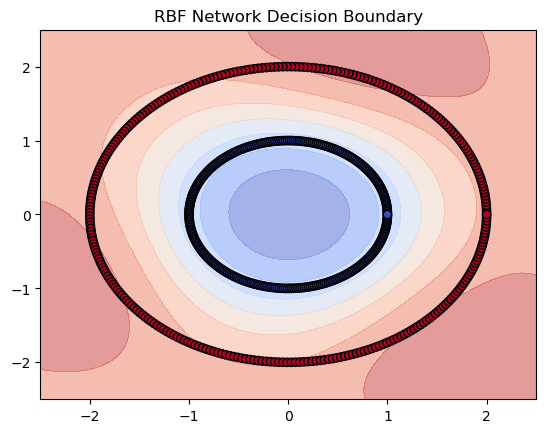

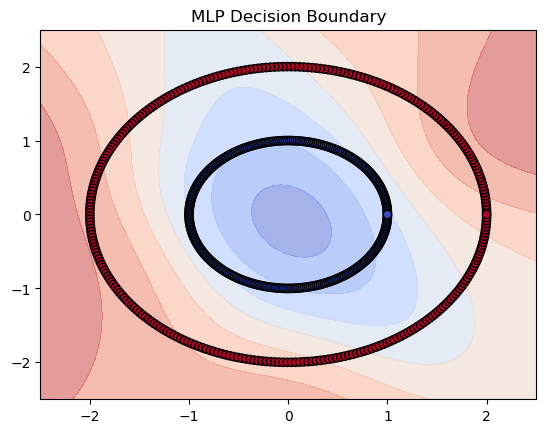

In [ ]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    with torch.no_grad():
        preds = torch.sigmoid(model(grid)).reshape(xx.shape)

    plt.contourf(xx, yy, preds.numpy(), alpha=0.5, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.show()

plot_decision_boundary(rbf_net, X, y, "RBF Network Decision Boundary")
plot_decision_boundary(mlp, X, y, "MLP Decision Boundary")